# Miguel Angel Ruiz Ortiz
## Procesamiento de Lenguaje Natural
## Tarea 3: DTRs (Distributional Term Representations) & Feature Selection

In [ ]:
from pathlib import Path
from typing import Literal
from collections import Counter
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager as fm

In [2]:
# Set the emoji-supporting font
emoji_font = fm.FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')

En las siguientes celdas se encuentra el código para leer y procesar el corpus de "MEX-A3T". Se utiliza TweetTokenizer para tokenizar el texto.

In [3]:
def getCorpus(corpus_path: Path, labels_path: Path) -> tuple[list[str]]:
    with open(corpus_path, "r") as corpus_file, open(labels_path, "r") as labels_file:
        corpus = [line for line in corpus_file]
        labels = [line for line in labels_file]

    return corpus, labels

In [4]:
base_path = Path("../data")
mex_a3t_path = base_path / "MEX-A3T"

train_corpus_path = mex_a3t_path / "mex20_train.txt"
train_labels_path = mex_a3t_path / "mex20_train_labels.txt"
val_corpus_path = mex_a3t_path / "mex20_val.txt"
val_labels_path = mex_a3t_path / "mex20_val_labels.txt"

In [5]:
train_corpus, train_labels = getCorpus(train_corpus_path, train_labels_path)
val_corpus, val_labels = getCorpus(val_corpus_path, val_labels_path)
all_corpus = train_corpus + val_corpus

In [45]:
train_labels = [int(label) for label in train_labels]
val_labels = [int(label) for label in val_labels]
all_labels = train_labels + val_labels

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

train_corpus_tk = [tokenizer.tokenize(tweet) for tweet in train_corpus]
val_corpus_tk = [tokenizer.tokenize(tweet) for tweet in val_corpus]
all_corpus_tk = train_corpus_tk + val_corpus_tk

En la siguiente celda se encuentra el código para normalizar un vector y la bolsa de palabras que se programó en la tarea pasada.

In [ ]:
def normalize_vector(vector: np.ndarray) -> np.ndarray:
    """Normalize a 1D numpy array with l2 norm"""
    norm = np.sum(vector**2) ** 0.5
    # deal with case where norm is 0
    if norm < 1e-8:
        return vector

    return vector / norm


class BagOfWords:
    def __init__(
        self,
        weights_type: Literal["binary", "tf", "tfidf"] = "binary",
        normalize: bool = False,
        max_vocab_size: int = -1, # -1 means all vocabulary, otherwise the top max_vocab_size words are considered
    ):

        if weights_type not in ["binary", "tf", "tfidf"]:
            raise ValueError(
                'Invalid weights type. Must be one of "binary", "tf" or "tfidf"'
            )

        self.weights_type = weights_type
        self.max_vocab_size = max_vocab_size
        self.normalize = normalize
        self.vocab = set()
        self.vocab_order = {}  # word -> column index in the BoW matrix
        self.word_freq = {}  # word -> frequency in the training corpus

        # only for tfidf weights type. It precalculates the IDF termns which only depend on the training corpus
        self.word_idf = {}  # word -> IDF value after fit method

    def fit(self, corpus: list[list[str]]) -> np.ndarray:
        # extract vocabulary from training corpus and compute its BoW matrix

        corpus_words = []
        for doc in corpus:
            corpus_words += doc

        freq_dist = nltk.FreqDist(corpus_words).most_common() # list of tuples (word, freq) ordered by frequency
        
        if self.max_vocab_size > 0:
            freq_dist = freq_dist[: self.max_vocab_size]

        self.word_freq = dict(freq_dist)
        self.vocab_order = {
            word: idx
            for idx, (word, _) in enumerate(freq_dist)
        }

        self.vocab = set(self.vocab_order.keys())

        # reset the idf values for new fit
        self.word_idf = {}

        # construct the BoW matrix
        return self.transform(corpus)

    def transform(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix for a given corpus, assuming vocabulary has been extracted

        # validate this method is called after fit method
        if len(self.vocab) == 0:
            raise ValueError("Vocabulary has not been extracted in fit method yet")

        # construct the BoW matrix
        if self.weights_type == "binary":
            bow_matrix = self.bowBinary(corpus)
        elif self.weights_type == "tf":
            bow_matrix = self.bowTF(corpus)
        else:
            # tfidf case
            bow_matrix = self.bowTFIDF(corpus)

        if self.normalize:
            for i in range(len(corpus)):
                bow_matrix[i] = normalize_vector(bow_matrix[i])

        return bow_matrix

    def bowBinary(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix with binary weights

        bow_matrix = np.zeros((len(corpus), len(self.vocab)))

        for id_doc, doc in enumerate(corpus):
            for token in set(doc):
                if token in self.vocab:
                    bow_matrix[id_doc, self.vocab_order[token]] = 1

        return bow_matrix

    def bowTF(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix with frequency weights

        bow_matrix = np.zeros((len(corpus), len(self.vocab)))

        for id_doc, doc in enumerate(corpus):
            freq_doc = nltk.FreqDist(doc)

            for token in doc:
                if token in self.vocab:
                    bow_matrix[id_doc, self.vocab_order[token]] = freq_doc[token]

        return bow_matrix

    def bowTFIDF(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix with TF-IDF weights

        bow_matrix = np.zeros((len(corpus), len(self.vocab)), dtype=float)

        freq_all_docs = {i: nltk.FreqDist(doc) for i, doc in enumerate(corpus)}

        # compute IDF for each token if it is first time (i.e., only for training phase)
        if len(self.word_idf) == 0:
            for token in self.vocab:
                if (
                    sum([1 for i in range(len(corpus)) if token in freq_all_docs[i]])
                    == 0
                ):
                    print(token, self.word_freq[token])

                self.word_idf[token] = np.log(
                    len(corpus)
                    / sum([1 for i in range(len(corpus)) if token in freq_all_docs[i]])
                )

        # construct matrix
        for id_doc, doc in enumerate(corpus):
            freq_doc = freq_all_docs[id_doc]

            for token in doc:
                if token in self.vocab:
                    bow_matrix[id_doc, self.vocab_order[token]] = (
                        freq_doc[token] * self.word_idf[token]
                    )

        return bow_matrix

### 1. Programa y visualiza TCOR.

Puede hacer esto de forma similar a como el profesor lo hizo
en la Práctica 4 con DOR. El pesado puede ser el que el profesor sugirió en clase TCOR o
PPMI como lo sugiere Dan Jurafsky; hacer al menos dos gráficas, la de constelación de
palabras y subconjunto para ver algunas palabras con flechas.

La siguiente función calcula la matriz de co-ocurrencias de las palabras, cuya entrada (i,j) es el número de veces que aparece el término i en el contexto del término j. El contexto es una ventana de N palabras a la izquiera y a la derecha del término j, en algún documento del corpus dado.

In [8]:
def compute_coocurrence_matrix(
    corpus: list[list[str]], context_window: int, max_vocab_size: int = -1
) -> tuple[np.ndarray, dict[str, int]]:
    """Compute co-ocurrence matrix F, such that F[i,j] is the number of times term i appears in the context of term j, that means the number of times term i was
    at a distance less or equal than context_window in a document of the corpus. 
    When max_vocab_size is -1 means all vocabulary is considered, otherwise the top max_vocab_size words (by frequency) are considered.
    The function returns a tuple with the matrix and the dictionary { word: row/column position in matrix }, respectively.
    """
    corpus_words = []
    for doc in corpus:
        corpus_words += doc

    freq_dist = nltk.FreqDist(corpus_words).most_common() # list of tuples (word, freq) ordered by frequency
        
    if max_vocab_size > 0:
        freq_dist = freq_dist[: max_vocab_size]

    vocab_mapping = {
        word: idx
        for idx, (word, _) in enumerate(freq_dist)
    }

    corpus_words = set(vocab_mapping.keys())
    
    vocab_size = len(corpus_words)

    co_occur_matrix = np.zeros((vocab_size, vocab_size), dtype=float)

    # the following computes in co_occur_matrix[i,j] the number of times term i appears in the context of term j
    for doc in corpus:
        for word_pos in range(len(doc)):
            word = doc[word_pos]
            
            if word not in vocab_mapping:
                continue
            
            word_id = vocab_mapping[word]

            context = doc[
                max(0, word_pos - context_window) : word_pos + context_window + 1
            ]  # when word_pos + context_window exceeds the number of elements in doc, Python ignores it and considers the last elements

            for word_neigh in context:
                if word_neigh in vocab_mapping:
                    word_neigh_id = vocab_mapping[word_neigh]
                    co_occur_matrix[word_neigh_id, word_id] += 1

    return co_occur_matrix, vocab_mapping

La siguiente función calcula la matriz TCOR a partir de la matriz de co-ocurrencias. A través de un parámetro booleano se puede especificar si se deben normalizar los vectores asociados a cada palabra (por defecto es True).

In [9]:
def compute_tcor(
    co_occur_matrix: np, normalize: bool = True
) -> np.ndarray:
    """Compute TCOR matrix based on the co-occurrence matrix. The entry (i,j) is a function of the number of times term i is used in the context of term j.
    """
    vocab_size = co_occur_matrix.shape[0]

    tcor = np.zeros((vocab_size, vocab_size))

    # the following updates tcor[i,j] as the weighting (1+log(co_occur_matrix[i,j]))*log(|V|/T_k), where T_k is the number of different terms that co-ocurred with term i
    for word_id in range(vocab_size):
        nonzero_ids = co_occur_matrix[word_id].nonzero()[
            0
        ]  # indices of word_vec with values different than zero
        num_terms_doc = len(
            nonzero_ids
        )  # number of different terms that co-occurred with term word_id

        for term_id in nonzero_ids:
            tcor[word_id, term_id] = (
                1 + np.log10(co_occur_matrix[word_id, term_id])
            ) * np.log10(vocab_size / num_terms_doc)

    if normalize:
        for i in range(tcor.shape[0]):
            tcor[i] = normalize_vector(tcor[i])

    return tcor

Calculamos TCOR sobre todo el corpus.

In [10]:
co_occur_matrix, vocab_mapping = compute_coocurrence_matrix(all_corpus_tk, context_window=5)
tcor_all = compute_tcor(co_occur_matrix)
inverse_vocab_map = {i: word for word, i in vocab_mapping.items()} # mapping row/column index -> word

Para visualizar una constelación de palabras, se escogió de manera manual algunas palabras (y emojis) y se agregaron 1000 palabras aleatorias de todo el corpus.

In [11]:
subwords = [
    "reputa",
    "lame",
    "madrugada",
    "espacio",
    "estupido",
    "men",
    "premios",
    "astros",
    "hermosas",
    "reputisima",
    "👎",
    "basuras",
    "perdone",
    "nmmn",
    "putos",
    "loca",
    "pinche",
    "hdp",
    "mierda",
    "joto",
    "quiero",
    ":(",
    "amable",
    "vida",
    "trabajo",
    "feliz",
    "escuela",
    "de",
    "la",
    "a",
    "😍",
]

In [12]:
num_random_words = 1000
np.random.seed(0)
random_indices = np.random.choice(len(vocab_mapping), num_random_words, replace=False)
target_words = [inverse_vocab_map[i] for i in random_indices] + subwords

In [13]:
target_words[:50]

['mega-error',
 'ahogaron',
 'léxico',
 'fundara',
 'llamándome',
 '💃🏻',
 '#reynosafollow',
 'listos',
 'recuperar',
 'muñeco',
 'explicóeldr',
 'americanista',
 'aciertos',
 'roja',
 'años',
 'habre',
 'p',
 'tenías',
 'mero',
 'tuyo',
 'gustarte',
 '76',
 'preocupe',
 '#luchona',
 'vicio',
 'babosadas',
 'tata',
 'comrpobado',
 'van',
 'crepúsculo',
 'sj',
 '#panamá',
 'pez',
 'inevitable',
 'desamor',
 '😏',
 'no.lo',
 'mentalizando',
 'facil',
 'mame',
 'enamórate',
 'chupan',
 'cuando',
 'vendes',
 'contestaran',
 'pasado',
 'mark',
 'desmaye',
 'aca',
 'manejando']

Construimos la submatriz de TCOR asociada a las palabras para la constelación.

In [14]:
target_matrix = np.array([tcor_all[vocab_mapping[word]] for word in target_words])

Después con esta matriz se realiza reducción de dimensión con el algoritmo TSNE (el profesor nos permitió utilizar Scikit-Learn para esto) para poder visualizar los vectores de las palabras en una gráfica 2D.

In [15]:
reduced_matrix = TSNE(n_components=2).fit_transform(target_matrix)

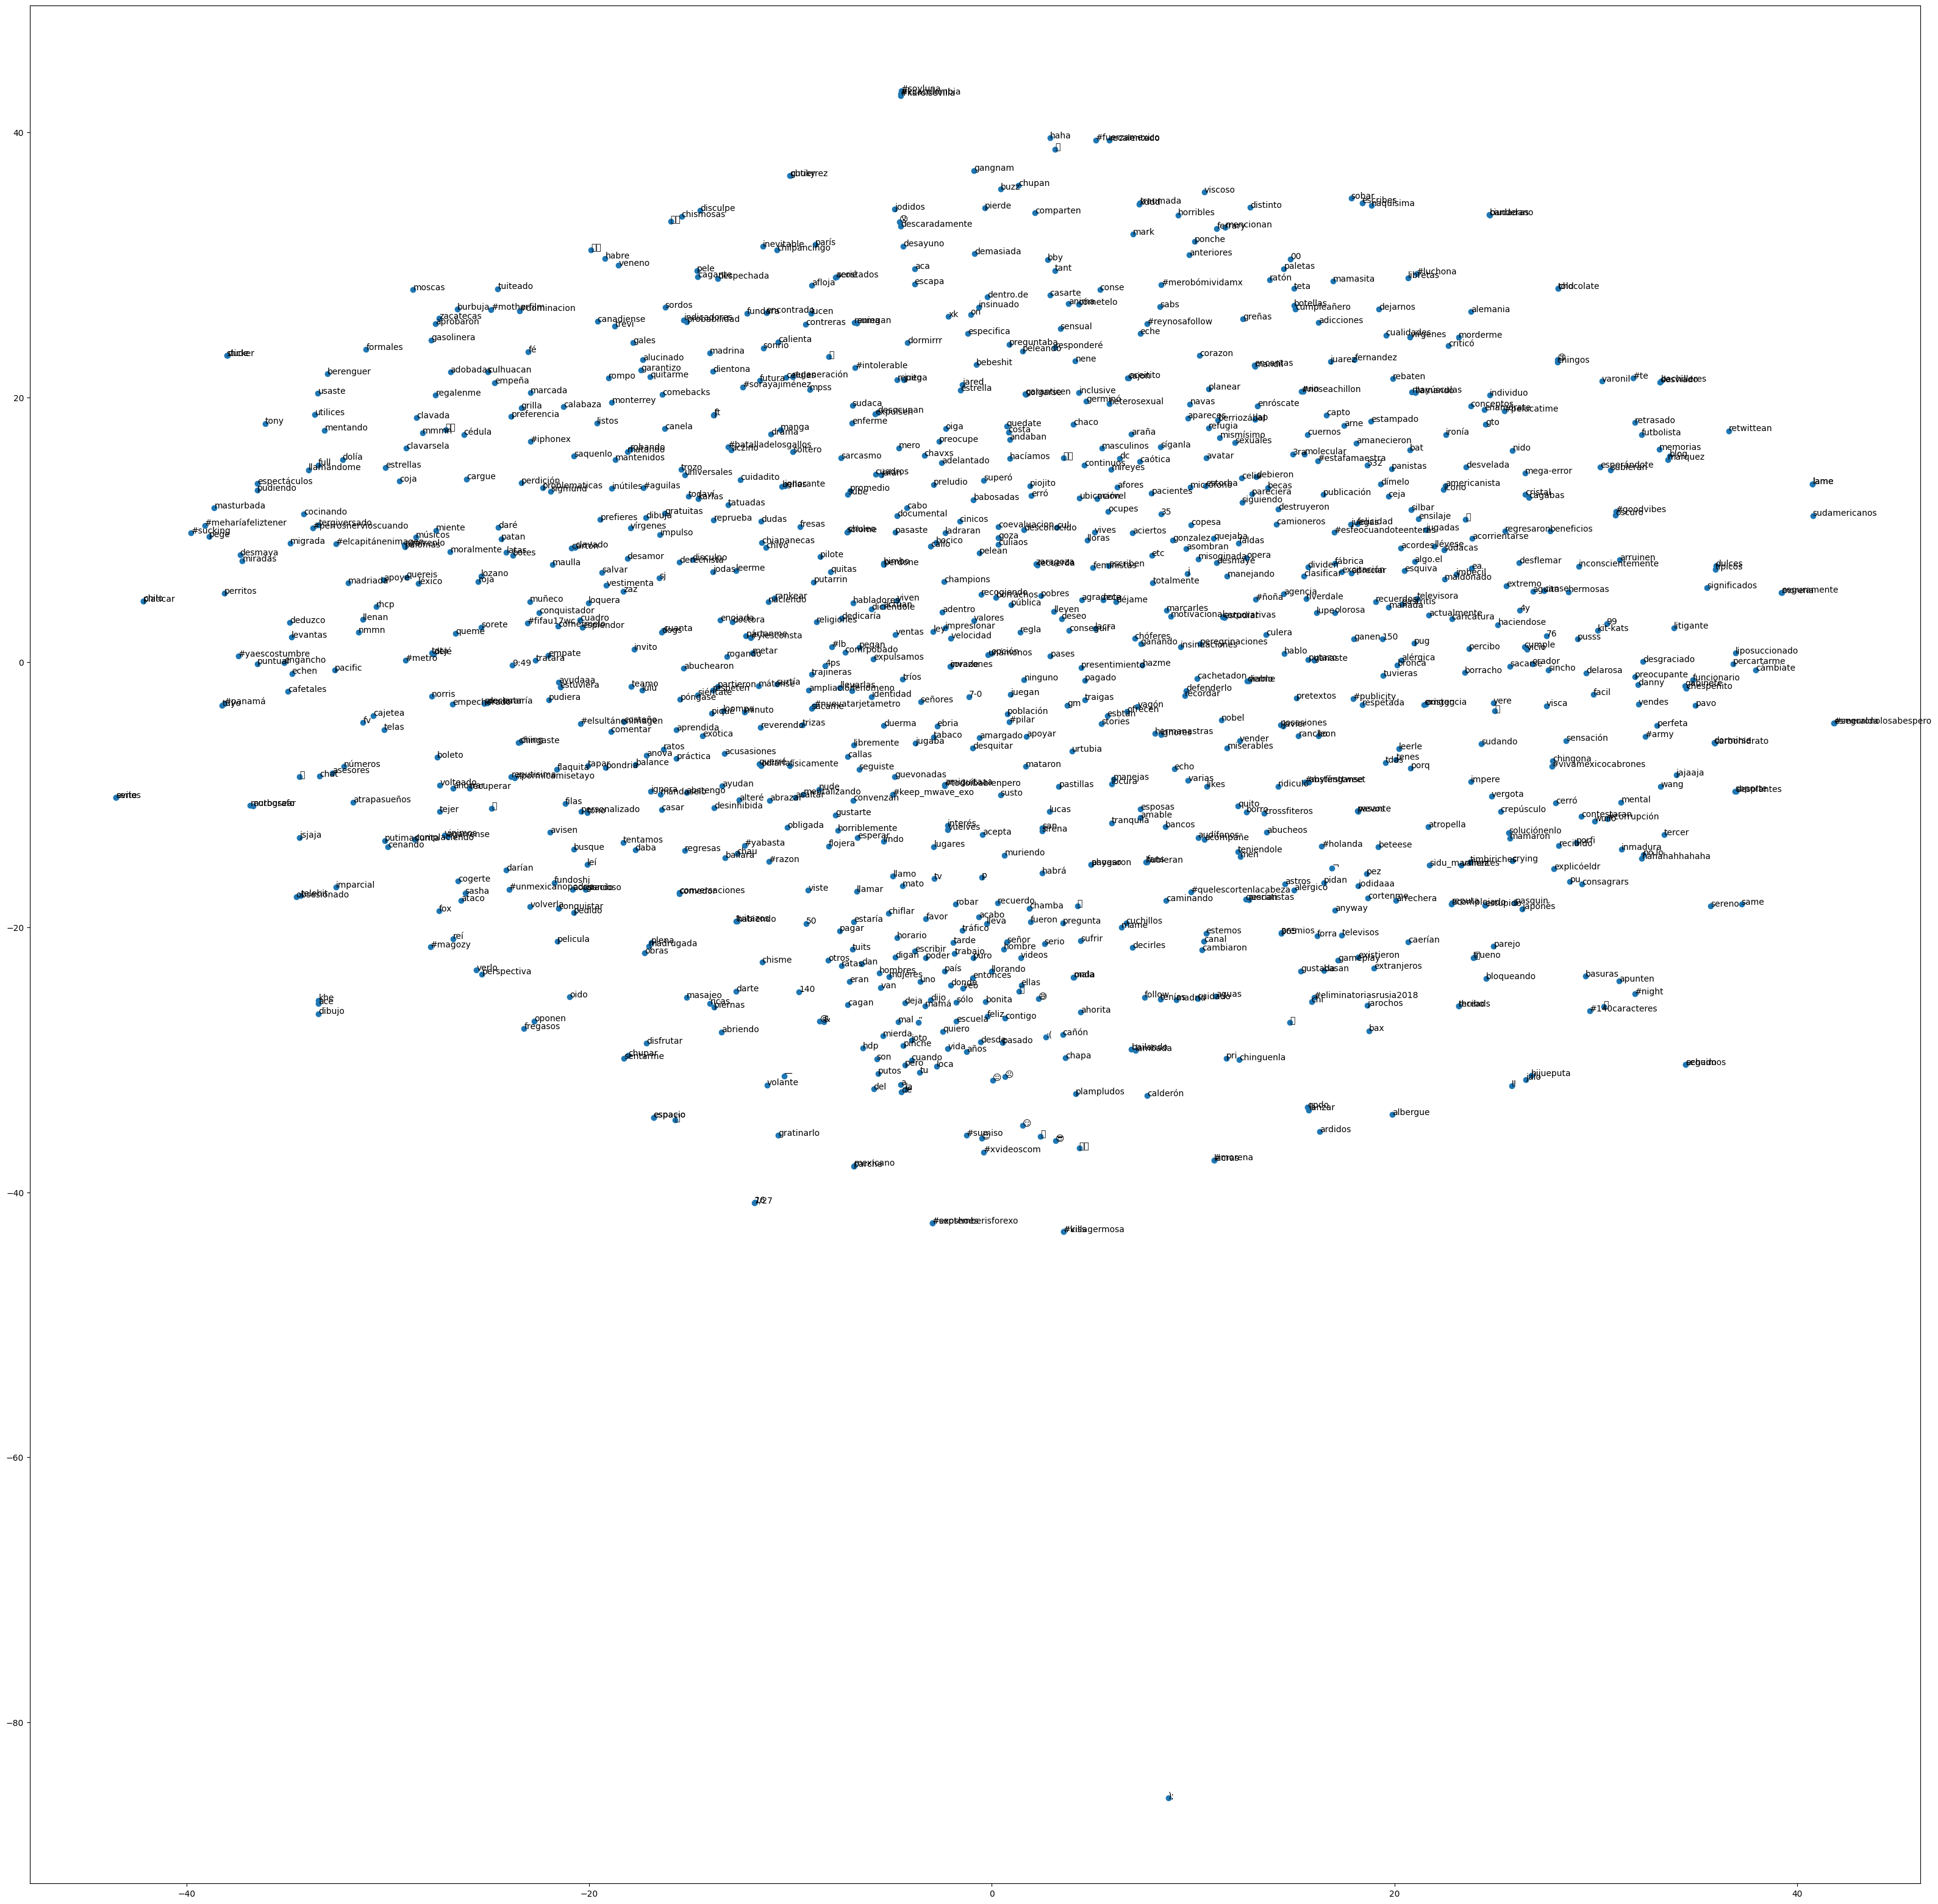

In [17]:
plt.figure(figsize=(40,40), dpi=100)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1])

for word_id, word in enumerate(target_words):
    x = reduced_matrix[word_id, 0]
    y = reduced_matrix[word_id, 1]
    plt.annotate(word, (x,y))
    

Ahora sólo representamos las palabras que escogimos manualmente con flechas en el mismo plano 2D. 

In [18]:
reduced_submatrix = np.array([reduced_matrix[i] for i, word in enumerate(target_words) if word in subwords])

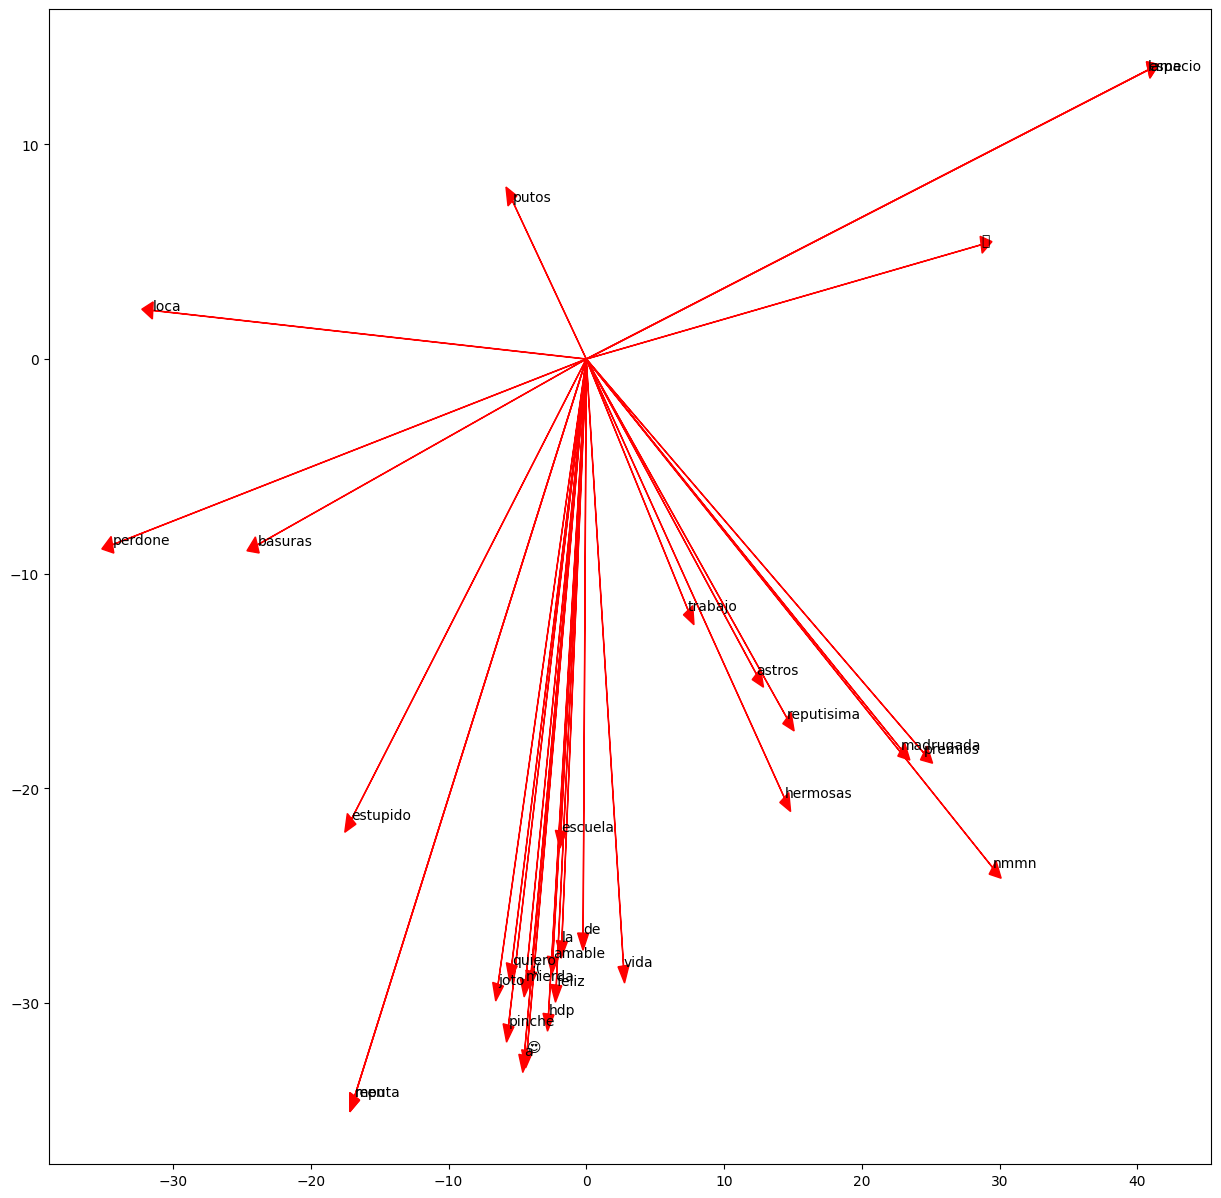

In [20]:
plt.figure(figsize=(15,15))

for word_id, word in enumerate(subwords):
    x = reduced_submatrix[word_id, 0]
    y = reduced_submatrix[word_id, 1]
    plt.arrow(0, 0, x, y, width=1e-2, head_width=0.8, head_length=0.8, fc="r", ec="r")
    plt.annotate(word, (x,y))
    

En la constelación de palabras es curioso cómo hay una palabra que se aleja de toda la constelación, y esa palabra es "):". Además, en la parte de abajo de la constelación se observa un cluster con 8 emojis cerca, lo cual nos podría estar indicando que se utilizan en contextos similares. Sobre la gráfica de flechas, podemos observar un cluster de palabras malas que están apuntando hacia abajo, lo cual es muy interesante pues demuestra que TCOR está juntando estas palabras malas que podrían usarse en contextos similares. Sin embargo, cabe resaltar que en este mismo cluster se encuentran palabras buenas que pensaríamos no se usan esos contextos, como "vida", "amable", "feliz" y "escuela". Por lo que no podemos afirmar que el algoritmo está agrupando "palabras malas" y "palabras buenas" como quisiéramos.

### 2. Programa y visualia Random Indexing.

Puedes hacer esto reusando parte del código del profesor en la Práctica 4 con DOR. Hacer al menos dos gráficas, la de constelación de palabras y subconjunto para ver algunas palabras con flechas.

Recordemos que Random Indexing realiza lo siguiente:
1. A cada contexto (e.g., una palabra) se le asigna un vector aleatorio sparse con algunos 1's y -1's, el cual es llamado vector índice.
2. A cada palabra se le asigna el vector que es la suma de los vectores índices cuyo contexto contiene a la palabra, llamado vector de contexto.

Esto se puede lograr mediante la multiplicación de la matriz de co-ocurrencias con la matriz R que contiene en sus filas a los vectores índices. Para convencernos de esto, recuerde que si A y B son matrices, entonces la fila i de AB es la combinación pesada de las filas de B, donde los pesos están dados por la fila i de A (en [este artículo de Medium](https://ghenshaw-work.medium.com/3-ways-to-understand-matrix-multiplication-fe8a007d7b26) se explica esta manera de ver a la multiplicación de matrices). Supongamos que F es la matriz de co-ocurrencias y R la matriz con los vectores índices en sus filas. Entonces la fila i de FR es la combinación pesada de los vectores índices, donde los pesos están dados por la fila i de F. La entrada F[i,j] es el número de veces que aparece el término i en el contexto del término j, por lo que se debe sumar F[i,j] veces el vector índice del término j (i.e., fila j de R) al momento de calcular el vector de contexto del término i. Al sumar sobre todos los términos de contexto j, se obtiene la fila i de FR para representar a la palabra i. Justamente esto es Random Indexing.

La siguiente función implementa random indexing, la cual recibe la matriz de co-ocurrencias, la dimensión de los vectores índices, a proporción de entradas que van a ser distintas de cero (0.3 por defecto), y un parámetro booleano que indica si se debe normalizar los vectores de las palabras al final (True por defecto). 

In [21]:
def get_random_indexing(co_occur_matrix: np.ndarray, dim: int, non_zeros_prop: float = 0.3, normalize: bool = True) -> np.ndarray:
    """Class for the random indexing algorithm, which approximates co-occurrence matrix F with F*R, where R is a random matrix such that its row i is the
    index vector for term i. The index vector is a sparse vector of dimension dim with a small number of randomly distributed 1's and -1's. The proportion of 
    non-zero entries are non_zeros_prop (number between 0 and 1).
    """
    if non_zeros_prop <= 0 or non_zeros_prop >= 1:
        raise ValueError("non_zeros_prop, the proportion of non-zero entries for index vectors, should be in (0, 1).")
    
    vocab_size = co_occur_matrix.shape[0]
    n_nonzeros = int(dim*non_zeros_prop)
    
    # create projection matrix R 
    projection_matrix = np.zeros((vocab_size, dim)) 
    
    for i in range(vocab_size):
        non_zero_ids = np.random.choice(dim, n_nonzeros, replace=False) # choose the entries that are non-zero
        non_zeros_entries = np.random.choice([-1, 1], n_nonzeros)
        
        for pos, j in enumerate(non_zero_ids):
            projection_matrix[i, j] = non_zeros_entries[pos]
            
    dtr = co_occur_matrix@projection_matrix
    
    if normalize:
        for i in range(vocab_size):
            dtr[i] = normalize_vector(dtr[i])
            
    return dtr

A continuación se realiza el random indexing con la matriz de co-ocurrencias que ya habíamos calculado, considerando vectores índices de dimensión 1000. 

In [22]:
random_indexing = get_random_indexing(co_occur_matrix, dim=1000)

Construimos la submatriz obtenida con Random Indexing asociada a las palabras para la constelación.

In [23]:
target_matrix = np.array([random_indexing[vocab_mapping[word]] for word in target_words])

Reducción de dimensión con el algoritmo TSNE.

In [24]:
reduced_matrix = TSNE(n_components=2).fit_transform(target_matrix)

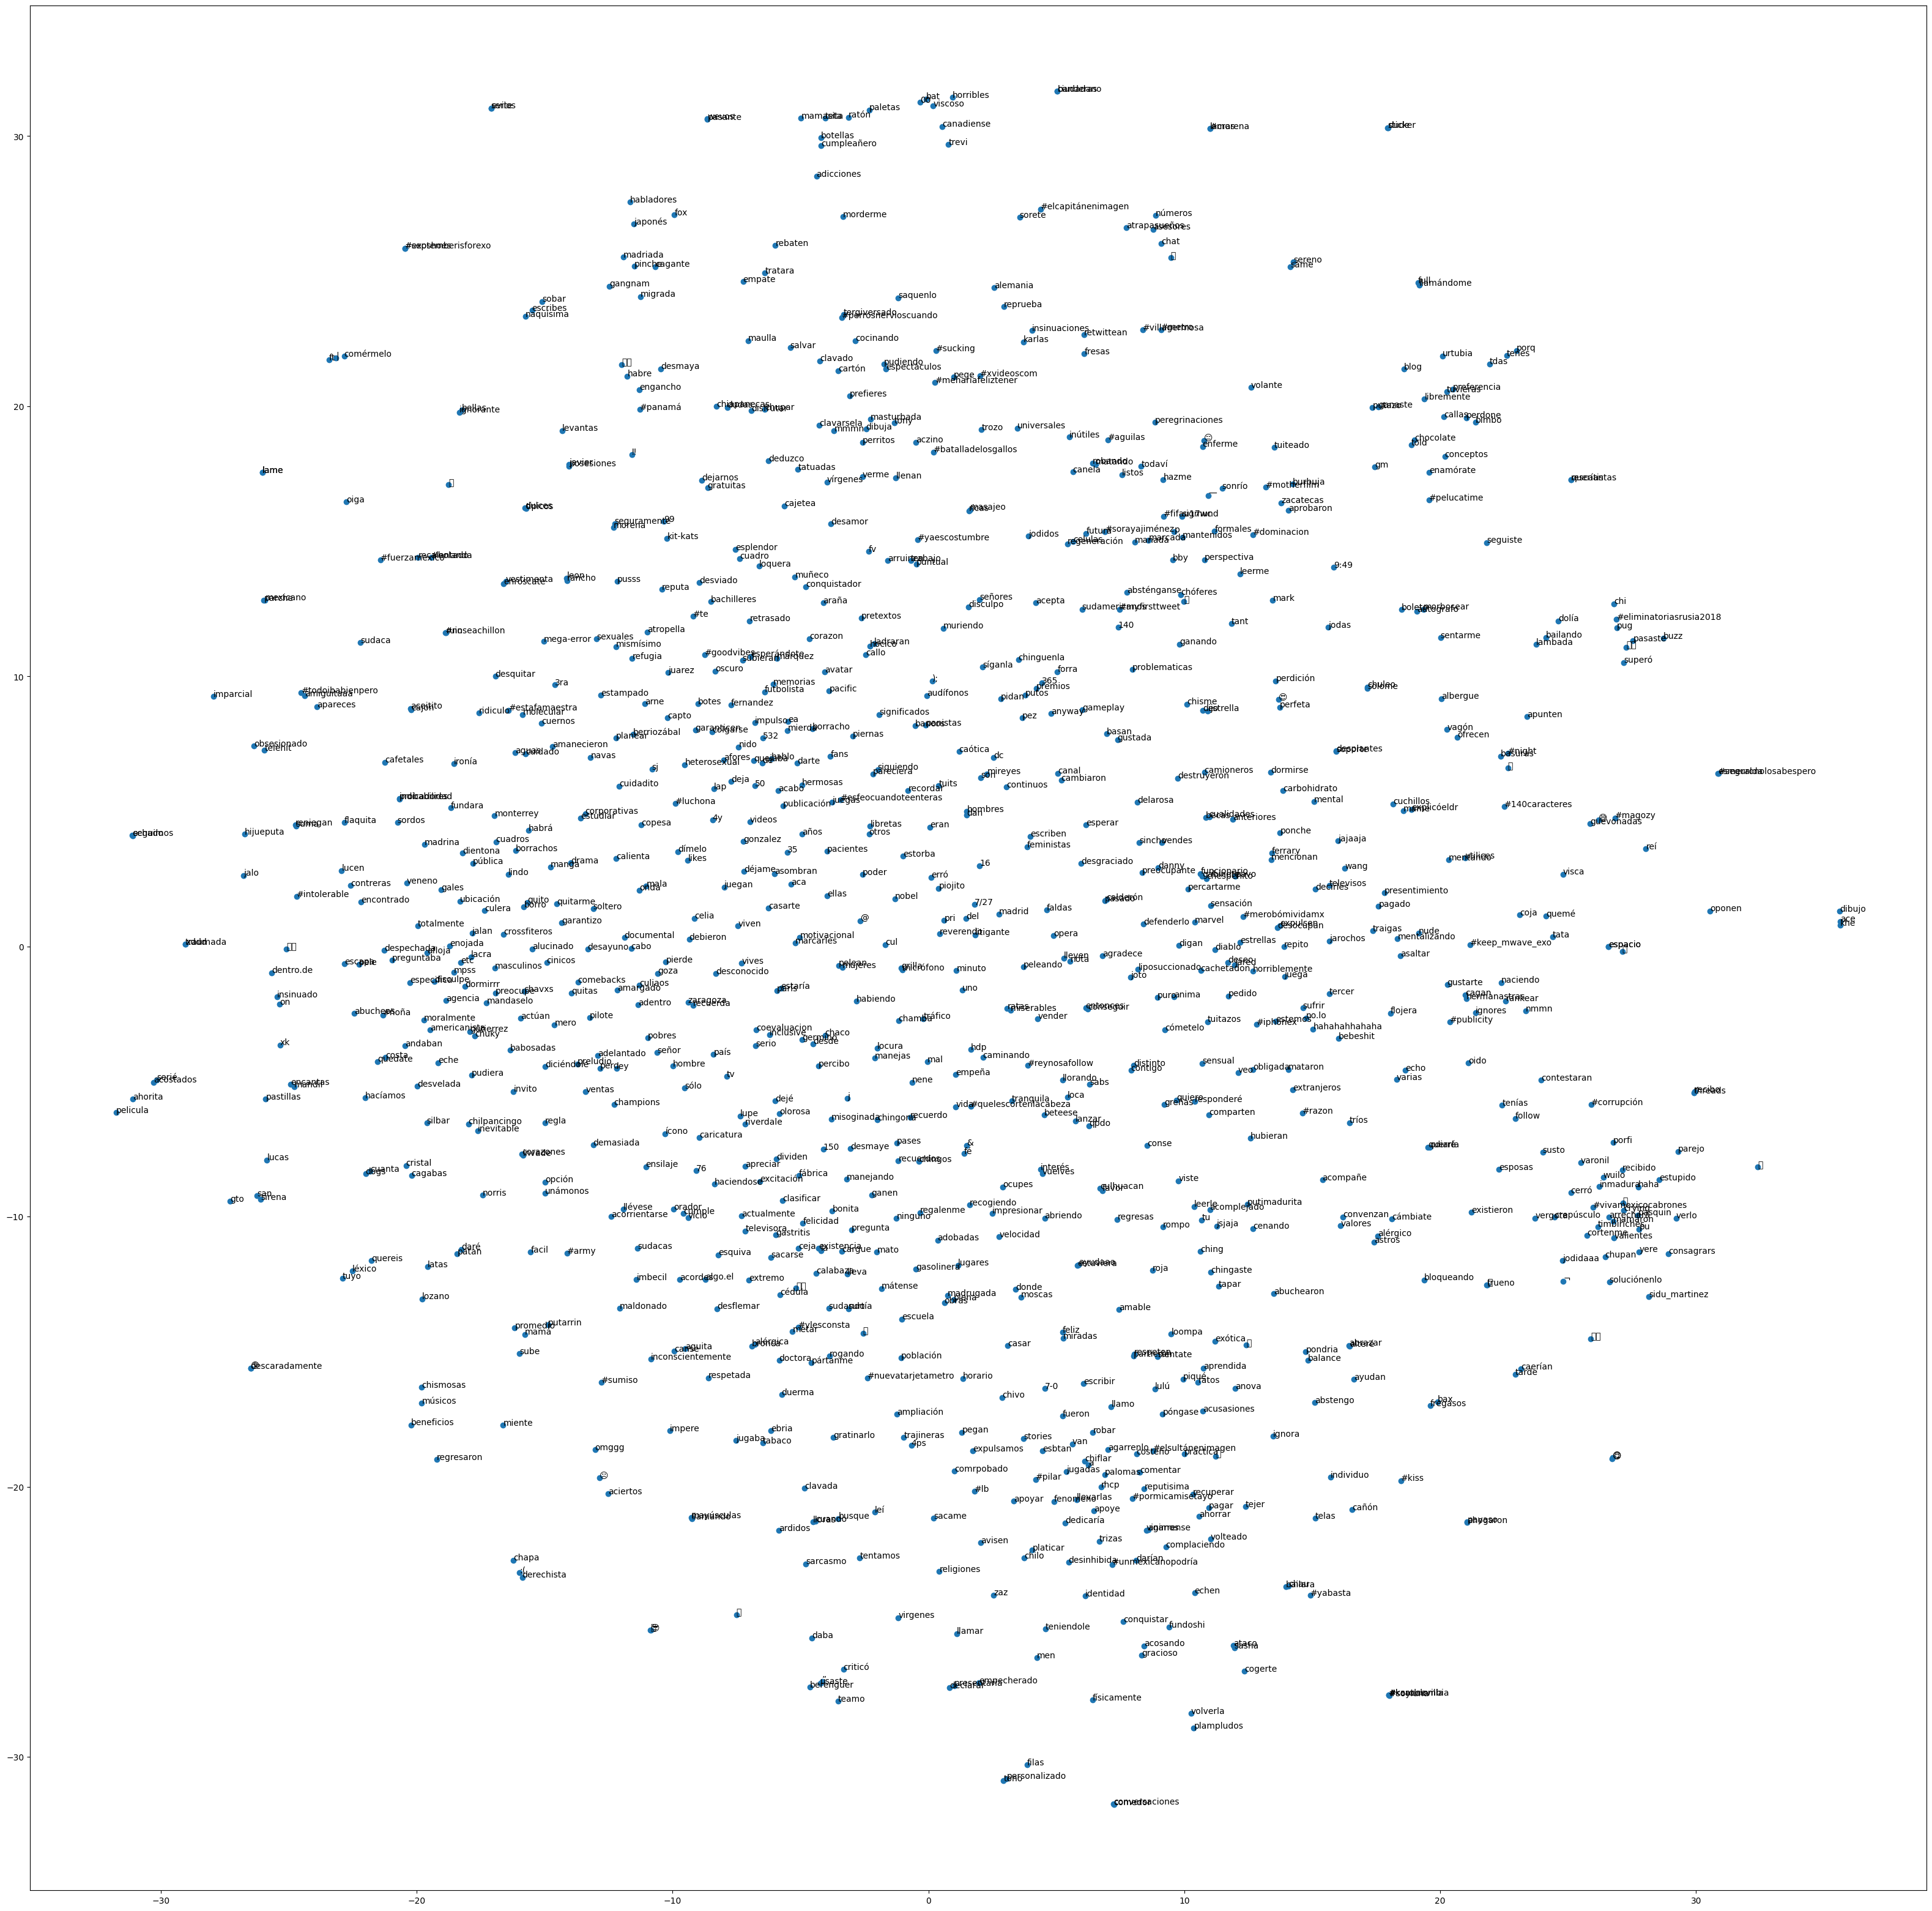

In [26]:
plt.figure(figsize=(40,40), dpi=100)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1])

for word_id, word in enumerate(target_words):
    x = reduced_matrix[word_id, 0]
    y = reduced_matrix[word_id, 1]
    plt.annotate(word, (x,y))

Ahora sólo representamos las palabras que escogimos manualmente con flechas en el mismo plano 2D. 

In [27]:
reduced_submatrix = np.array([reduced_matrix[i] for i, word in enumerate(target_words) if word in subwords])

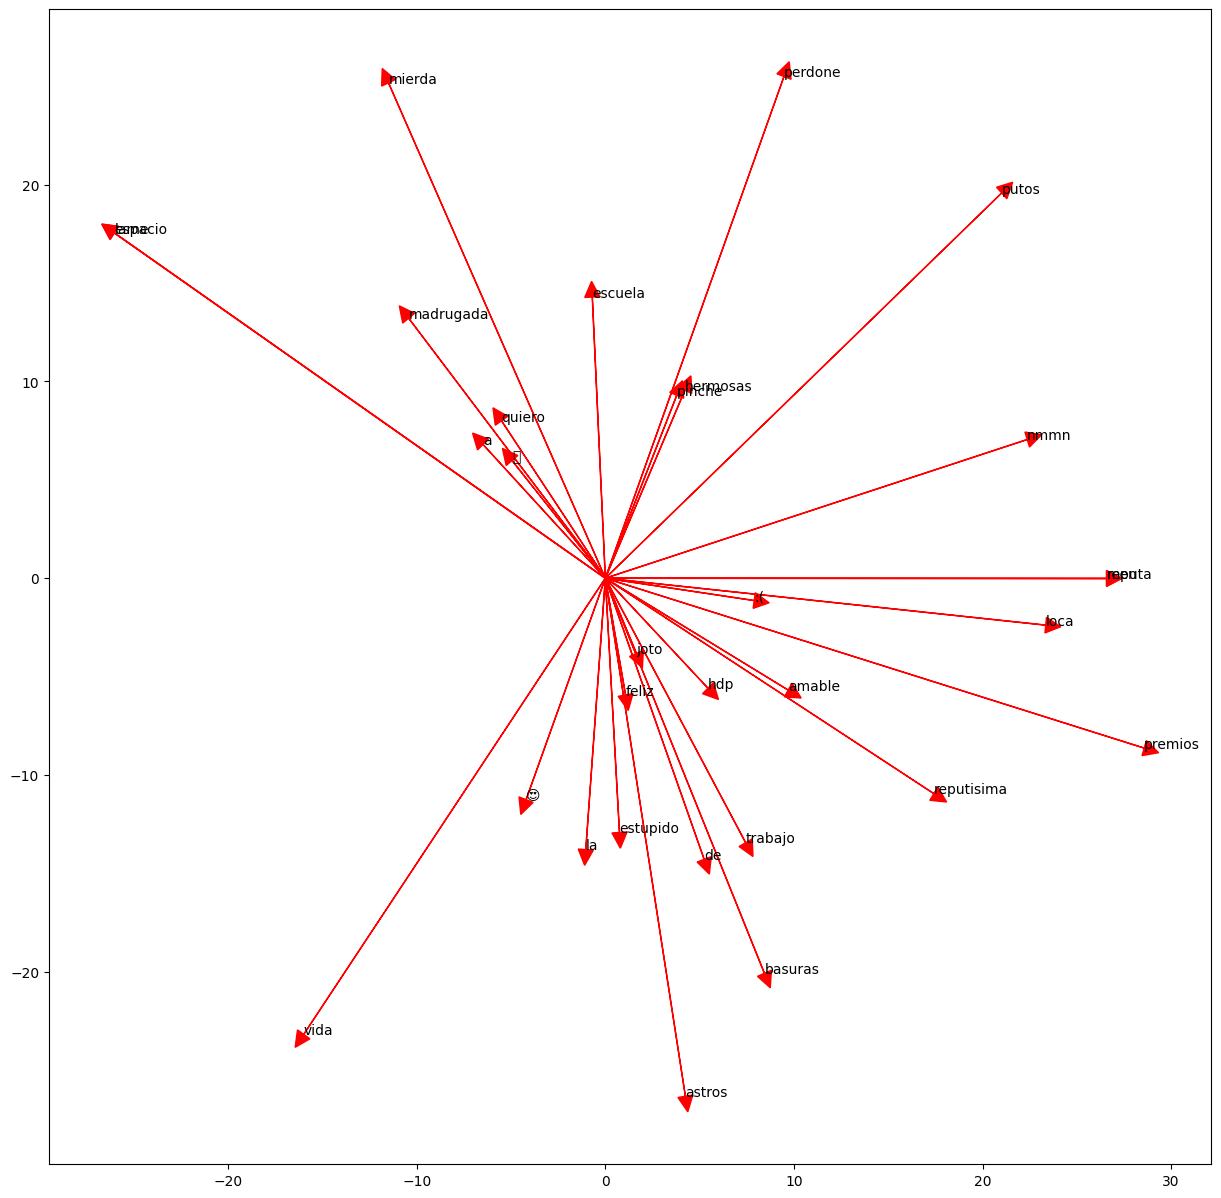

In [30]:
plt.figure(figsize=(15,15))

for word_id, word in enumerate(subwords):
    x = reduced_submatrix[word_id, 0]
    y = reduced_submatrix[word_id, 1]
    plt.arrow(0, 0, x, y, width=1e-2, head_width=0.8, head_length=0.8, fc="r", ec="r")
    plt.annotate(word, (x,y))

A diferencia de la constelación de palabras obtenida con TCOR, la que obtuvimos con Random Indexing no muestra algún patrón a simple vista. Por ejemplo, esperaba que los emojis de nuevo se agruparan pero ahora están de manera dispersa. Tampoco hay alguna palabra que esté particularmente alejada de toda la constelación. Por otro lado, en la gráfica con las flecha se observa que las palabras están distribuidas de manera más uniforme sobre el plano, es decir, no hay alguna dirección preferida por algún subconjunto de palabras como sí lo hubo usando TCOR. Parece ser que TCOR es mejor que Random Indexing en ese sentido de capturar direcciones que tienen algún significado, como un sentido negativo de las palabras como lo observamos. Por otro lado, recordemos que para Random Indexing se utilizó una dimensión de 1000, y pudiera ser que no fue lo suficientemente grande como para capturar el sentido de las palabras como lo hace TCOR.

### 3. Comparación de DTR con BOW-TFIDF en clasificación

Use alguna de las DTRs anteriores por separado de alguna forma para clasificación de
documentos (e.g., promedio de vectores de términos en cada documento para representar).
Compárelas contra un BoW-TFIDF de 5000 palabras más frecuentes.

La siguiente función calcula la representación de un documento a partir de una DTR y obteniendo el centroide de los vectores asociados a las palabras que contiene el documento. Esta recibe una DTR en forma de matriz, donde cada fila representa una palabra, el corpus tonenizado, el mapeo { palabra -> índice de filas en DTR }, y un booleano para indicar si se debe normalizar al final el vector del documento (True por defecto).

In [34]:
def get_document_vectors(dtr: np.ndarray, corpus: list[list[str]], vocab_mapping: dict[str, int], normalize: bool = True)-> np.ndarray:
    """Computes the vector representation of each document in corpus, as the average vector of the words in the document, where word vectors are given in the matrix dtr.
    vocab_mapping is the dictionary { word: row position in dtr }
    """
    doc_vecs = np.zeros((len(corpus), dtr.shape[1]))
    
    for i, doc in enumerate(corpus):
        length_doc = len(doc)
        
        for word in doc:
            if word in vocab_mapping:
                doc_vecs[i] += dtr[vocab_mapping[word]]
                
        doc_vecs[i] = doc_vecs[i]/length_doc
        
        if normalize:
            doc_vecs[i] = normalize_vector(doc_vecs[i])
        
    return doc_vecs

Calculamos la BoW con TFIDF, con las 5000 palabras más frecuentes.

In [33]:
bow_builder = BagOfWords(weights_type="tfidf", normalize=True, max_vocab_size=5000)
bow_tr = bow_builder.fit(train_corpus_tk)
bow_val = bow_builder.transform(val_corpus_tk)

Calculamos las representaciones vectoriales de los documentos utilizando la DTR de Random Indexing.

In [35]:
docs_randind_tr = get_document_vectors(random_indexing, train_corpus_tk, vocab_mapping)
docs_randind_val = get_document_vectors(random_indexing, val_corpus_tk, vocab_mapping)


Función para evaluar las representaciones vectoriales de los documentos a través de clasificación con SVM como en la tarea pasada (se reutilizó esta función).

In [36]:
def evaluate_docs_classification(
    X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray
) -> tuple[svm.SVC, dict]:
    """Evaluates docs representation matrix (X_train, X_val for training and validation, resp.) using a linear SVM classifier and grid search for hyperparameter tuning"""

    grid = GridSearchCV(
        svm.SVC(kernel="linear", class_weight="balanced"),
        {"C": [0.05, 0.12, 0.25, 0.5, 1, 2, 4]},
        cv=5,
        scoring="f1_macro",
        n_jobs=-1,
    )

    best_classifier = grid.fit(X_train, y_train)

    print("Mejor parámetro:", grid.best_params_)

    y_pred_val = best_classifier.predict(X_val)

    print("Matriz de confusión:\n", confusion_matrix(y_val, y_pred_val))
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred_val))

    report_dict = classification_report(y_val, y_pred_val, output_dict=True)

    return best_classifier, report_dict

Evaluación de BoW

In [37]:
classifier_bow, report_bow = evaluate_docs_classification(
    bow_tr, train_labels, bow_val, val_labels
)

Mejor parámetro: {'C': 0.5}
Matriz de confusión:
 [[364  54]
 [ 39 130]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       418
           1       0.71      0.77      0.74       169

    accuracy                           0.84       587
   macro avg       0.80      0.82      0.81       587
weighted avg       0.85      0.84      0.84       587



Evaluación de Random Indexing

In [38]:
classifier_randind, report_randind = evaluate_docs_classification(
    docs_randind_tr, train_labels, docs_randind_val, val_labels
)

Mejor parámetro: {'C': 4}
Matriz de confusión:
 [[350  68]
 [ 42 127]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       418
           1       0.65      0.75      0.70       169

    accuracy                           0.81       587
   macro avg       0.77      0.79      0.78       587
weighted avg       0.82      0.81      0.82       587



Se puede observar cómo Random Indexing logra construir una representación vectorial de los documentos adecuada, pues se tienen resultados en el problema de clasificación similares a los resultados con BoW, ligeramente menores, pero con un costo computacional mucho menor. En mi computadora personal, la evaluación de BoW tardó casi 12 min y la de Random Indexing tardó casi 2 min.

### 4. Pares de palabras más parecidas

Bajo la representación TCOR de los términos, y asumiendo un vocabulario de 5000
palabras, muestre por orden de mayor similitud coseno (ver chp 6 del libro de Dan) los
10 pares de palabras más parecidas en toda la colección.

Calculamos TCOR del corpus utilizando sólo las 5000 palabras más frecuentes

In [39]:
co_occur_matrix, vocab_mapping = compute_coocurrence_matrix(all_corpus_tk, context_window=5, max_vocab_size=5000)
tcor_tr = compute_tcor(co_occur_matrix)

Construimos mapeo {índice de fila -> palabra}

In [40]:
inverse_vocab_map = {i: word for word, i in vocab_mapping.items()}

La similitud de dos vectores unitarios está dada por su producto punto (OJO, sólo aplica si son unitarios). Si W es la matriz TCOR, donde cada vector de una palabra está normalizado, entonces la entrada (i,j) de la multiplicación W\*W^T es el producto punto del vector de la palabra i con el vector de la palabra j, por definición de multiplicación de matrices. Por lo que W\*W^T contiene todos las similitudes entre cada par de palabras. A continuación se calculan las similitudes, se construye una lista con tuplas (palabra i, palabra j, similitud), y se ordena de mayor a menor con respecto a la similitud.

In [41]:
similarities = tcor_tr @ tcor_tr.T # compute similarities
vocab_size = 5000
similarities_flat = [
    (inverse_vocab_map[i], inverse_vocab_map[j], similarities[i, j])
    for i in range(vocab_size)
    for j in range(i + 1, vocab_size)
]
similarities_flat.sort(key=lambda data: data[-1], reverse=True)

Los 10 pares de palabras más parecidas en el corpus son las siguientes:

In [42]:
similarities_flat[:10]

[('chongos', 'zamoranos', np.float64(0.9951223055436222)),
 ('garcia', 'marquez', np.float64(0.9754710392856831)),
 ('jesús', 'delgado', np.float64(0.9658012672856542)),
 ('star', 'wars', np.float64(0.9639628373987876)),
 ('garcía', 'márquez', np.float64(0.9592021430055823)),
 ('dino', 'saurio', np.float64(0.9498760488217456)),
 ('#una', '#noche', np.float64(0.9434719360015765)),
 ('alentar', 'selesiooon', np.float64(0.928681462315069)),
 ('#reggaetonlento', '#heydj', np.float64(0.9262476669643991)),
 ('#karolsevilla', '#ruggeropasquarelli', np.float64(0.926247666964399))]

Se puede observar que hay pares que suelen estar siempre juntos, como "Star Wars", "Garcia Marquez" y "Chongos Zamoranos". Es interesante cómo TCOR logra detectar este tipo de similitudes entre palabras, considerando en qué contextos se usan. 

### 5. Pares de documentos más parecidos

Bajo alguna representación de documentos hecha en esta tarea, y asumiendo un vocabulario de 5000 
palabras, muestre por orden de más similitud coseno (ver chp 6 del libro
de Dan) 10 pares de documentos más parecidos en toda la colección (no muestres pares
de documentos que contengan exactamente substrings uno del otro; pues hay algo de
redundancia en los datos). Muestre el texto que contienen y muestre la categoría de cada
uno.

Para este ejercicio, utilizamos la representación de los documentos a través de TCOR. Además, normalizamos los vectores de cada documento (por defecto en nuestra función).

In [44]:
docs_tcor = get_document_vectors(tcor_tr, all_corpus_tk, vocab_mapping)

De nuevo calculamos las similitudes con la matriz W\*W^T, donde W es la matriz que tiene en sus filas los vectores asociados a cada documento. Después construimos una lista de de tuplas (tweet i, label i, tweet j, label j, similitud entre tweets), pero sólo con aquellos pares de tweets que no comparten palabras en común como se nos indica.

In [47]:
similarities_docs = docs_tcor @ docs_tcor.T
words_per_doc = {i: set(all_corpus_tk[i]) for i in range(len(all_corpus_tk))}
similarities_docs_flat = [
    (all_corpus[i], all_labels[i], all_corpus[j], all_labels[j], similarities_docs[i, j])
    for i in range(len(all_corpus_tk))
    for j in range(i + 1, len(all_corpus_tk))
    if len(words_per_doc[i].intersection(words_per_doc[j])) == 0
]
similarities_docs_flat.sort(key=lambda data: data[-1], reverse=True)

10 pares de documentos más parecidos que no contengan palabras en común, junto con su categoría:

In [49]:
for tweet1, label1, tweet2, label2, score in similarities_docs_flat[:10]:
    print("---------")
    print(f"Tweet 1, label {label1}:", tweet1)
    print(f"Tweet 2, label {label2}:", tweet2)
    print(f"Similitud: {score:.6f}")

---------
Tweet 1, label 0: ¿Como es que a las putas les va mejor en el amor que uno?

Tweet 2, label 0: Se pasan de verga, pero no me queda de otra, al menos por mi no pasa.

Similitud: 0.951385
---------
Tweet 1, label 0: ¿Como es que a las putas les va mejor en el amor que uno?

Tweet 2, label 0: Todo bien, digo si soy medio marica pero bueeeeeno se trata de ser adulto y no andar de rencoroso. Eso está más cagazon

Similitud: 0.948867
---------
Tweet 1, label 0: Lo bueno es que soy prieta y saben que soy extranjera y yo les digo que no se hablar en francés 😂

Tweet 2, label 1: Pero un día te voy a tapar el culo mientras te estoy lamiendo la pantunfla a ver si te da una embolia, hija de tu puta madre

Similitud: 0.948042
---------
Tweet 1, label 0: No entiendo qué te molesta de mi, tú me dijiste cosas feas, por eso me retiré, pero el amor no se puede esconder, tu eres mi Luna mi vida

Tweet 2, label 0: @USUARIO Jajaja...y mas jajajajaa y todavía creen que la gente es tonta! Lo unico 

### 6. Palabras más relevantes

Implemente Ganancia de Información o Chi2 como lo sugiere Baeza-Yates (no función de sklearn ni similar) para descubrir el top 50 de las palabras más relevantes de TODA la colección. Haga una gráfica también con la herramienta de [word_cloud](https://amueller.github.io/word_cloud/) dónde el tamaño de la palabra corresponda a su ganancia de información o Chi2.

A continuación se encuentra la función que encuentra las k características (features) más importantes en un dataset X para predecir las categoría y. Se utiliza el método Chi Square para ello. La función regresa una lista de tuplas (índice de característica, score).

In [50]:
def select_k_best_feat(X: np.ndarray, y: list[int], k: int) -> list[tuple[int, float]]:
    """Select k best features on dataset X for predicting labels y, using the Chi square method.
    The function returns the column indices of the best features of X and their scores, in a list of tuples.
    Labels in y should be integers 0, ..., M-1, where M is the number of classes
    """
    N = X.shape[0]  # number of data vectors in X
    n_feats = X.shape[1]  # number of features

    data_per_label = Counter(y)

    n_classes = len(data_per_label)  # number of classes

    chi_square = np.zeros(
        (n_feats, n_classes)
    )  # chi_square[i, p] will be the chi square metric that quantifies the lack of independence between term i and class p

    n = np.zeros(
        (n_feats, n_classes)
    )  # n[i,p] is the number of vectors that contains term i and are in class p

    for data_id, data in enumerate(X):
        nonzero_ids = data.nonzero()[0]  # terms that contain the data vector
        for i in nonzero_ids:
            n[i, y[data_id]] += 1

    for i in range(n_feats):
        n_i = n[i, :].sum()  # number of data vectors that contain term i

        for p in range(n_classes):
            n_p = data_per_label[p]

            if n_i > 0 and N-n_i >0:
                chi_square[i, p] = (N * (N * n[i, p] - n_p * n_i) ** 2) / (
                    n_p * n_i * (N - n_p) * (N - n_i)
                )  # formula from Baeza Yates, section 8.5.6
            else:
                # consider the case when denominator in the formula is 0
                chi_square[i, p] = 0

    chi_square_avg = np.zeros(n_feats)

    probs_per_class = np.array(
        [data_per_label[p] / N for p in range(n_classes)]
    )  # probabilities per class

    for i in range(n_feats):
        chi_square_avg[i] = (probs_per_class * chi_square[i, :]).sum()

    feats_ordered = [(i, chi_square_avg[i]) for i in range(n_feats)]
    feats_ordered.sort(key=lambda data: data[1], reverse=True)
    best_feats = feats_ordered[:k]
    best_feats.sort() # order according to indices

    return best_feats

Encontramos el top de 50 palabras más importantes con la función anterior. Se utiliza la representación de los documentos a través de TCOR.

In [52]:
k = 50
best_feats = select_k_best_feat(docs_tcor, all_labels, k)

Construimos un mapeo {palabra -> score}

In [53]:
word_score = {inverse_vocab_map[i]: score for i, score in best_feats}

In [54]:
word_score

{'#cruising': np.float64(40.85406209411785),
 'josé': np.float64(63.0336561111867),
 'votando': np.float64(41.979288215825314),
 '40': np.float64(44.65574378474665),
 'confieso': np.float64(49.34597350132599),
 'computadora': np.float64(62.705909187469075),
 '#sexy': np.float64(44.455580882190894),
 '🎃': np.float64(48.98309987607545),
 '🤦🏽\u200d♂': np.float64(48.35190045335969),
 'arroba': np.float64(76.19940914731751),
 'reputa': np.float64(78.42533239899727),
 'reputisima': np.float64(45.74701857041242),
 'lame': np.float64(46.272456237677154),
 '👿': np.float64(46.27025569645649),
 '#karma': np.float64(45.12141324992025),
 'actos': np.float64(42.80345869956517),
 'aporte': np.float64(80.2061674359797),
 'barrer': np.float64(41.801800078287364),
 'espacio': np.float64(46.75868685394761),
 'volviste': np.float64(42.933414909680664),
 'estupido': np.float64(121.85710068644832),
 'men': np.float64(56.35458021260807),
 'prisa': np.float64(48.11279366474797),
 'mostraste': np.float64(40.32

Visualizamos la nube de palabras de acuerdo a su score obtenido con Chi Square con WordCloud. Lamentablemente no se pueden visualizar emojis.

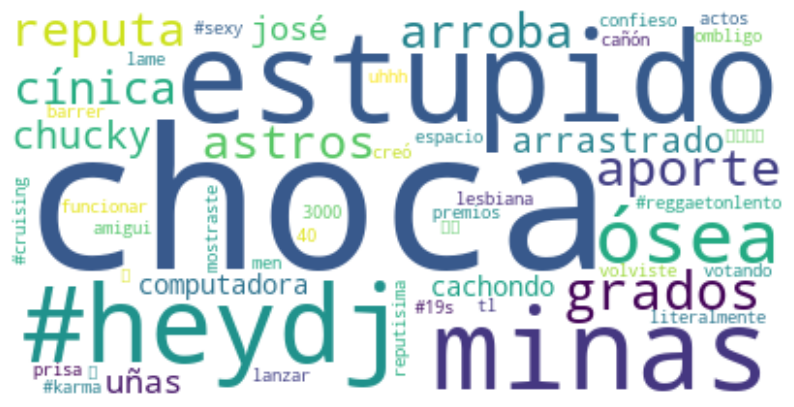

In [55]:
wc = WordCloud(background_color="white")
# generate word cloud
wc.generate_from_frequencies(word_score)

plt.figure(figsize=(10, 18))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

En la nube de palabras se visualizan las palabras más importantes en el dataset que permiten clasificar los textos adecuadamente. Entre más grande es la palabra, más es la dependencia de esa característica en los documentos con respecto a la categoría. Se puede visualizar que hay tanto palabras malas (e.g., "estupido") como buenas (e.g., "computadora"). Es curioso que no hay tantas malas palabras como se espera, pero tal vez es porque 50 es un número pequeño comparado con el número de palabras totales, y no nos permite ver cuáles otras palabras discriminan de manera más adecuada un documento.